# Setting CollaGAN's temperature


In [1]:
import tensorflow as tf

# USES ALL 4GB VRAM of my GeForce GTX 1050 Ti
# COMMENT THE FOLLOWING LINES TO USE THE DEFAULT VRAM
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
    )
# end of the VRAM usage configuration


import post_process
from ModelProxy import CollaGANModelProxy

collagan = CollaGANModelProxy("models/collagan-entcon/lambda-palette-1.0", palette_input=True, post_process=False, is_legacy_tf_saved_model=False, domain_dtype="int32")



2025-05-30 14:26:31.551988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 14:26:31.580482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 14:26:31.580534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 14:26:31.604751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 14:26:32.965370: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)


In [3]:
from matplotlib import pyplot as plt

def generate_batch_with_each_source_combination(model_name, number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    if mode == "random_batch":
        # chooses number_of_4batchs*4 indices of examples to load
        sample_numbers = tf.random.uniform([number_of_4batches*4], minval=0, maxval=dataset_loader.dataset_size, dtype=tf.int32)
        # sample_numbers = tf.sort(sample_numbers)
        print("Sample numbers:", sample_numbers.numpy())
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    batch_transpose = batch


    target_indices = tf.range(0, 4, dtype=tf.int32)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]

    genned_images = []
    temperatures = [10., 1.0, 0.1, 0.001, 0.]
    for tau in temperatures:
        collagan.set_temperature(tau)
        # print("Calling generate_from_multiple with tau:", tau)
        fake_images = collagan.generate_from_multiple(target_indices, source_images, training=(tau != 0))
        genned_images += [fake_images]

    target_images = tf.gather(batch_transpose, target_indices, axis=1, batch_dims=1)
    genned_images += [target_images]
    column_titles = ["$\\tau=" + str(temperature) + "$" for temperature in temperatures] + ["Ground Truth"]

    return genned_images, column_titles


example_indices = [1212, 1182, 1858, 1364]
images, titles = generate_batch_with_each_source_combination("collagan", sample_numbers=example_indices)
palettes = post_process.batch_extract_palette_ragged(tf.reshape(tf.transpose(images, [1, 0, 2, 3, 4]), shape=[-1, 64, 64, 4]))


2025-05-30 14:26:51.783973: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-30 14:26:54.475549: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:26:54.758910: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


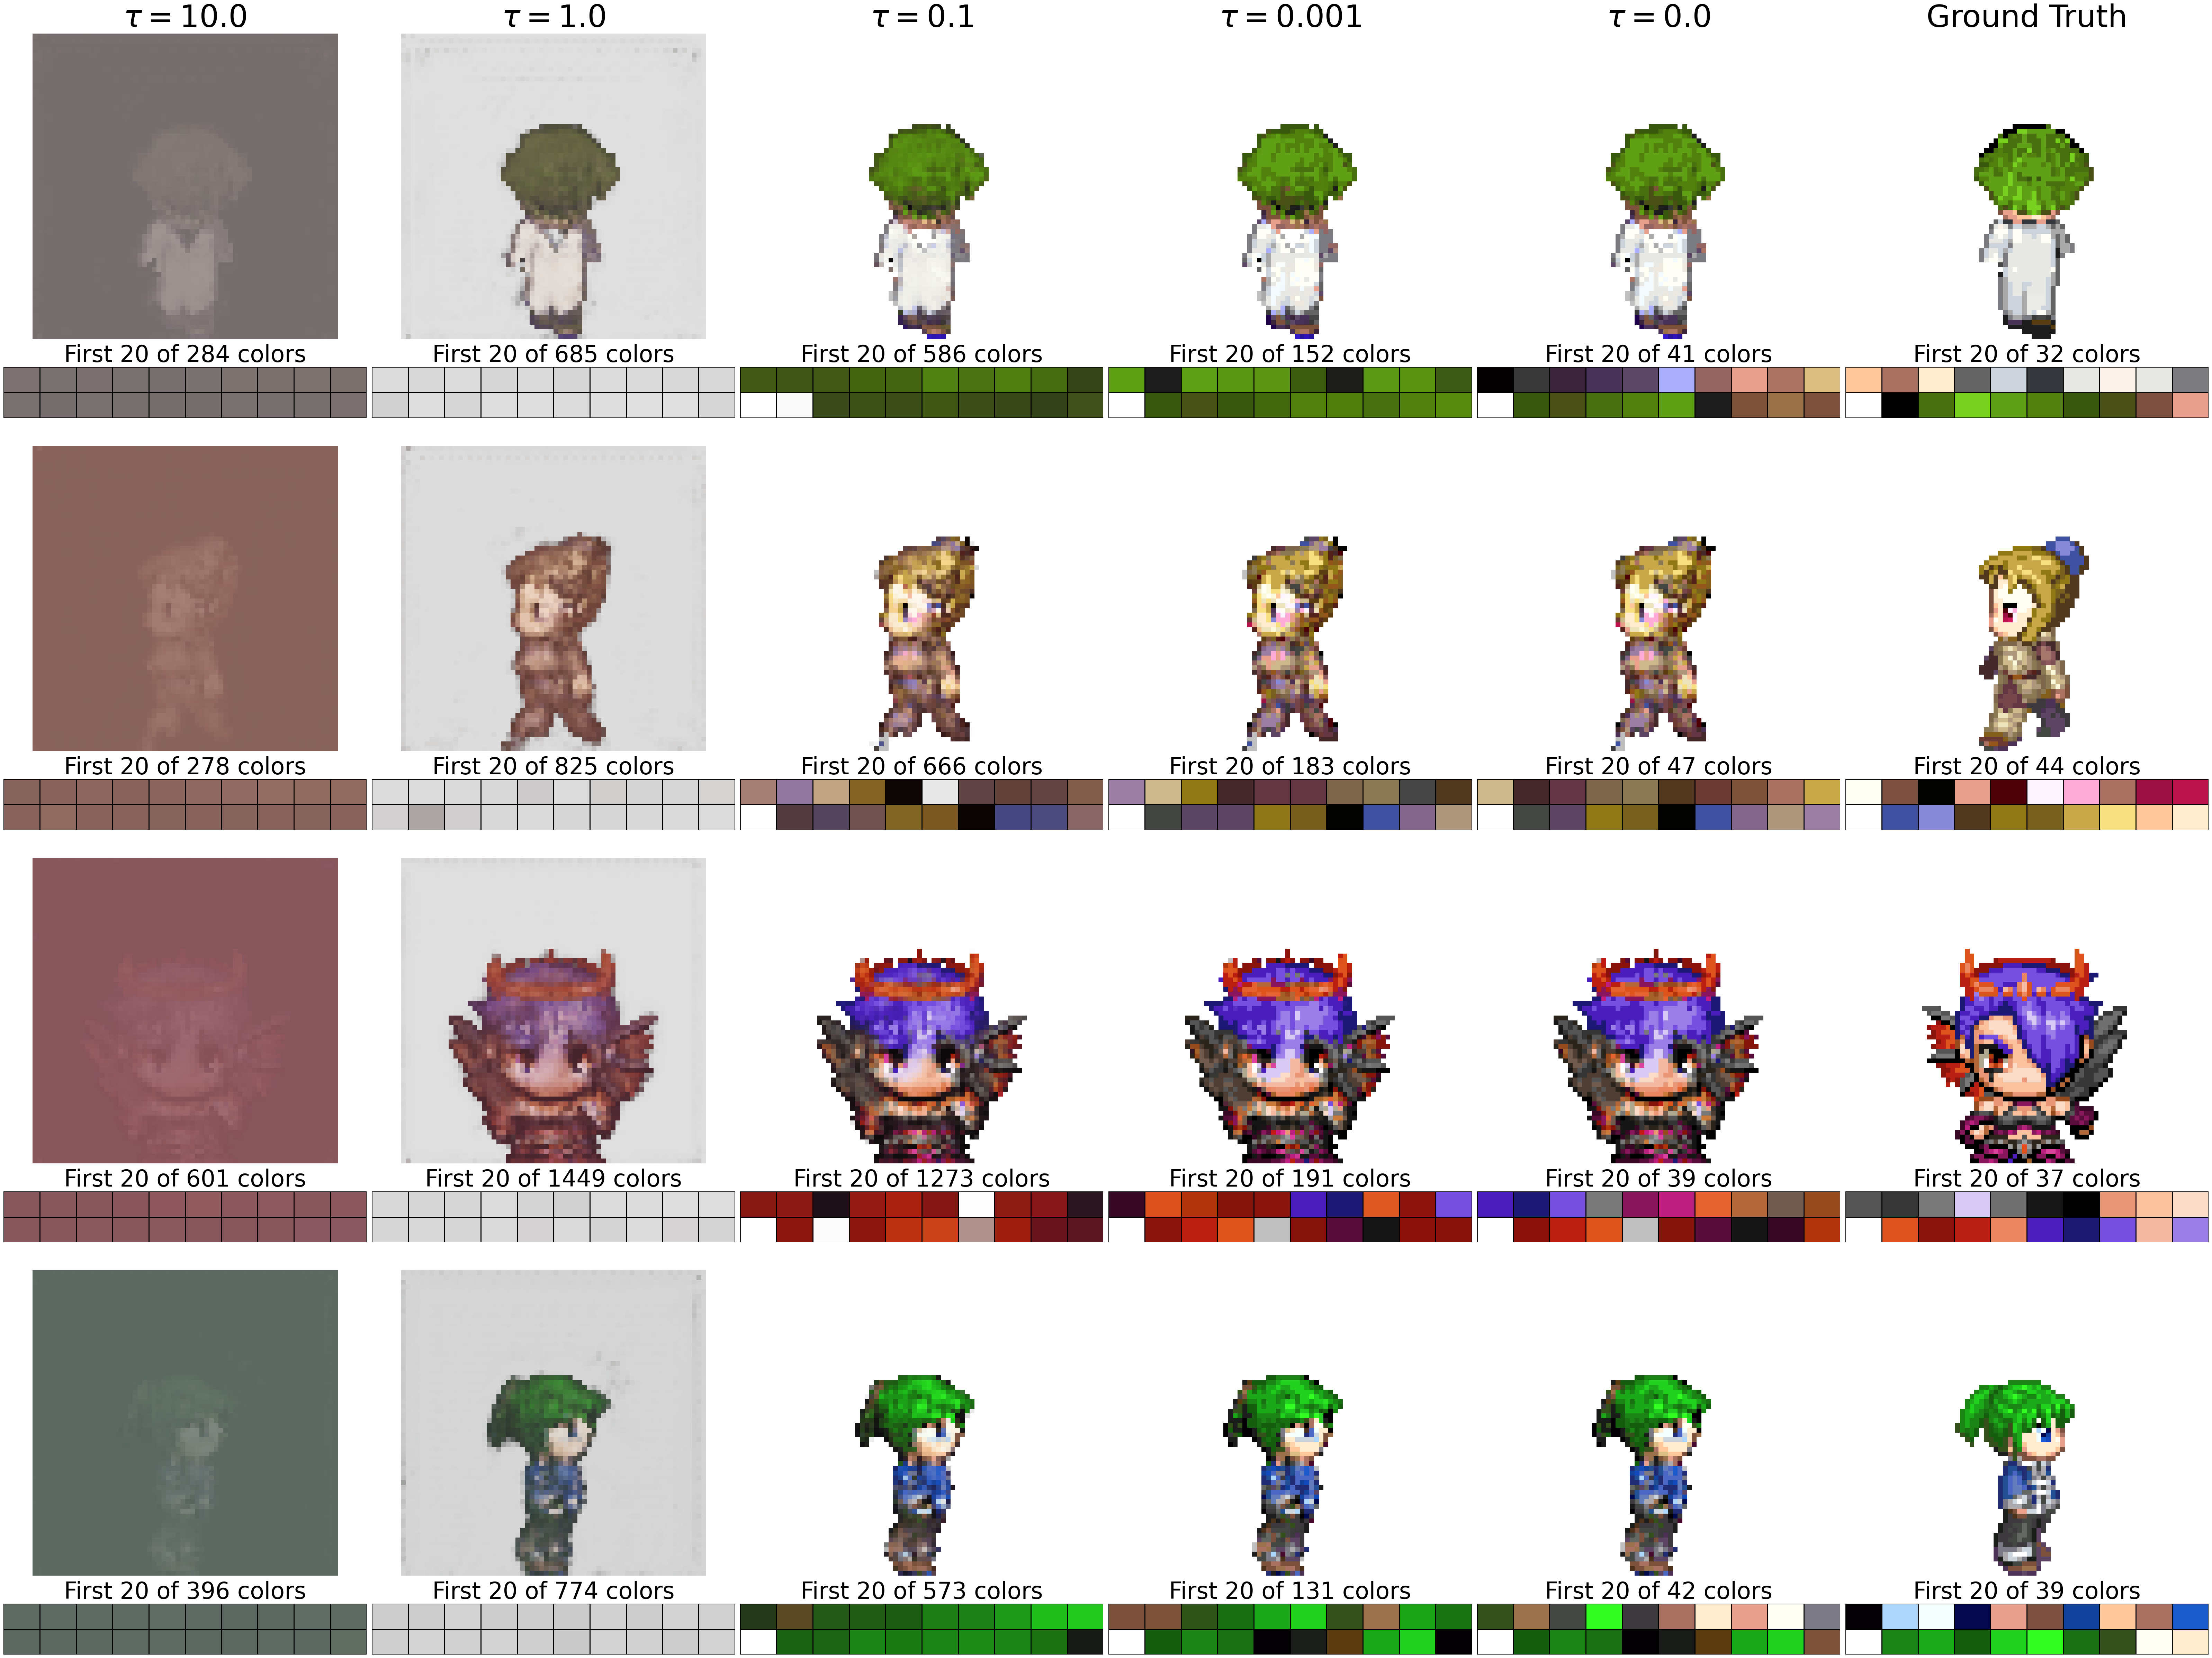

In [4]:
def plot_images(images, palettes, column_titles, sup_title=None):
    palettes = (palettes + 1) * 0.5
    # Calculate the number of rows needed (original images + palette rows)
    n_rows = len(images[0]) * 2  # Each image gets its own row and a palette row
    n_cols = len(images)

    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(8 * n_rows, 8 * n_cols),
                            gridspec_kw={'height_ratios': [6, 1] * len(images[0])})

    # Flatten axes for easier indexing if it's a 2D array
    if len(images) > 1:
        axes = axes.reshape(-1, len(images))
    else:
        axes = axes.reshape(-1, 1)

    for j, columns in enumerate(images):
        for i, image in enumerate(columns):
            # Image index (accounting for palette rows)
            img_row = i * 2
            palette_row = img_row + 1

            # Show the image
            if i == 0:
                axes[img_row, j].set_title(column_titles[j], fontsize=64)
            axes[img_row, j].imshow(tf.clip_by_value((image + 1) / 2, 0., 1.))
            axes[img_row, j].axis('off')

            # Show the palette below the image
            palette = palettes[i*n_cols+j]
            num_colors = len(palette)

            # Display first 20 colors or all if less than 20
            typical_num_colors_to_display = 20
            htnctd = half_typical_num_colors_to_display = typical_num_colors_to_display // 2
            num_colors_to_display = min(num_colors, typical_num_colors_to_display)
            display_palette = palette[:num_colors_to_display]
            for k, color in enumerate(display_palette):
                swatch = plt.Rectangle(((k%htnctd)/htnctd, (k//htnctd)*0.5), 1/htnctd, 1/2, color=color.numpy(), ec="black", lw=2)
                swatch.set_clip_path(swatch)
                axes[palette_row, j].add_patch(swatch)

            # Set palette title with total number of colors
            palette_title = f"First {typical_num_colors_to_display} of {num_colors} colors"
            axes[palette_row, j].set_title(palette_title, fontsize=48)
            axes[palette_row, j].axis('off')

    # make the figure have a transparent background
    fig.patch.set_alpha(0.0)
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.tight_layout()
    plt.show()

plot_images(images, palettes, titles)